## Рекомендательная система

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# читаем файлы
data_train = pd.read_csv('data/train.csv')
data_test = pd.read_csv('data/test.csv')
submission = pd.read_csv('data/sample_submission.csv')
train = data_train.copy()
test = data_test.copy()

C:\apps\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (8) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)
C:\apps\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## 1 EDA

In [3]:
# посмотрим, что вообще представляет из себя датасет
print('train.shape = ', train.shape)
train.head(5)

train.shape =  (857895, 14)


,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,Heather,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Linda Odom,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,DesertBlossom,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Connie L. Reaves,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,Mike P.,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0


In [4]:
# посмотрим на типы данных и количество пропущенных значений
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 857895 entries, 0 to 857894
Data columns (total 14 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   overall         857895 non-null  float64
 1   verified        857895 non-null  bool   
 2   reviewTime      857895 non-null  object 
 3   asin            857895 non-null  object 
 4   reviewerName    857719 non-null  object 
 5   reviewText      857616 non-null  object 
 6   summary         857725 non-null  object 
 7   unixReviewTime  857895 non-null  int64  
 8   vote            118740 non-null  object 
 9   style           444406 non-null  object 
 10  image           7142 non-null    object 
 11  userid          857895 non-null  int64  
 12  itemid          857895 non-null  int64  
 13  rating          857895 non-null  float64
dtypes: bool(1), float64(2), int64(3), object(8)
memory usage: 85.9+ MB


Есть немного пропусков в поле *reviewerName*. Cкорее всего, это никак не должно влиять на остальные данные. Посмотрим, как выглядят данные с пропущенными *reviewerName*. Видим, что в остальном данные выглядят ок, поэтому просто удалим этот столбец и будем идентифицировать пользователья только по *userid*. Дополнительно убедимся в этом, посмотрев на распределениe первоначальной оценки *overall* и разброс времени оставления отзывов для клиентов с наличием *reviewerName* и его отсутствием.

In [5]:
train[train.reviewerName.isna()].sample(3)

,overall,verified,reviewTime,asin,reviewerName,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
24606,5.0,True,"10 9, 2015",B0029J6HU2,NaN,Nice,Love,1444348800,NaN,NaN,NaN,20032,10382,1.0
612569,5.0,True,"04 30, 2018",B001UUEWIA,NaN,I gobbled these little things by the handful,Delicious,1525046400,NaN,{'Size:': ' 40 - Ounce'},NaN,103223,9783,1.0
84100,3.0,True,"02 1, 2016",B00BBVVJHK,NaN,"take too long to receivce it , but taste good",Three Stars,1454284800,NaN,{'Flavor:': ' Grape'},NaN,4801,21585,0.0


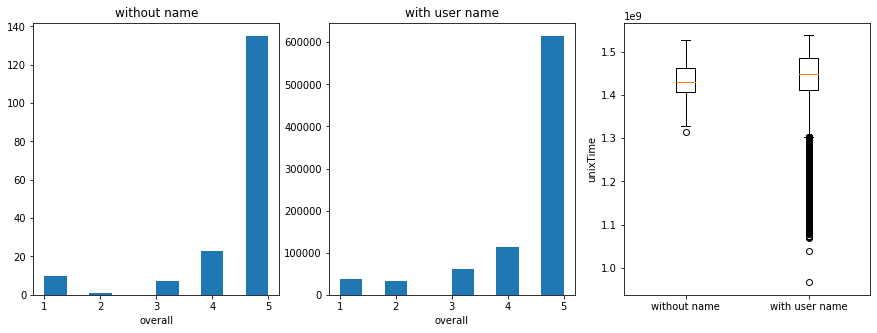

In [6]:
fig, axes = plt.subplots(1, 3, figsize = (15,5))
axes[0].set_title('without name')
axes[0].set_xlabel('overall')
axes[1].set_xlabel('overall')
axes[1].set_title('with user name')
axes[0].hist(train[train.reviewerName.isna() == True].overall)
axes[1].hist(train[train.reviewerName.isna() == False].overall)
axes[2].set_ylabel('unixTime')
axes[2].boxplot([train[train.reviewerName.isna()].unixReviewTime, train[train.reviewerName.isna() == False].unixReviewTime],
               labels=['without name', 'with user name'])
plt.show()

In [7]:
# удалим колонку reviewerName из тренировочного датасета
train.drop('reviewerName', axis = 1, inplace = True)
train

,overall,verified,reviewTime,asin,reviewText,summary,unixReviewTime,vote,style,image,userid,itemid,rating
0,5.0,True,"10 4, 2016",B01CPNIEQG,These are my FAVORITE spices in my collection....,Must Add to your Spice kitchen!,1475539200,NaN,NaN,NaN,102179,37138,1.0
1,5.0,True,"03 1, 2016",B006F63M8U,Add A package to my Coffee and it makes a good...,Milk Chocolate Swiis MIss Hot Cocoa Mix,1456790400,NaN,{'Size:': ' 60-0.73 oz Envelopes'},NaN,3625,17322,1.0
2,5.0,True,"06 26, 2016",B00112O8NG,"I love the Torani syrups, but not the prices o...","Love these sugar free syrups, but didn't love ...",1466899200,28,NaN,NaN,39495,5600,1.0
3,5.0,True,"09 5, 2013",B00MRAQUM8,Very fragrant. The price can't be beat. I do l...,Nice !,1378339200,NaN,NaN,NaN,72854,30249,1.0
4,5.0,True,"09 14, 2016",B000R7RN0G,These are my favorite jalapeno chips so far. T...,These are my favorite jalapeno chips so far,1473811200,NaN,{'Flavor:': ' Jalapeo'},NaN,74859,4349,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
857890,5.0,True,"04 2, 2013",B000H7ELTW,Next to the round variety hanging on my cherry...,next to the round variety............,1364860800,NaN,{'Flavor:': ' Dried Cherries'},NaN,59433,2566,1.0
857891,2.0,True,"12 13, 2015",B0012NI02O,Not my cup of tea.,Two Stars,1449964800,NaN,{'Package Quantity:': ' 1'},NaN,86473,5828,0.0
857892,4.0,False,"09 21, 2016",B000LKX6R8,"I really like these noodles, I just gave it on...",good but better value elsewhere,1474416000,NaN,{'Size:': ' Pack of 8'},NaN,88,3251,1.0
857893,4.0,True,"11 1, 2015",B00BUKL666,"I like these, they are the kind for a snack an...",Great selection,1446336000,NaN,NaN,NaN,41540,22208,1.0


In [8]:
# переведем дату в формат datetime. 
# Дублирующий столбец unixReviwTime удалать не будем, возможно с ним проще вычисления проводить
train.reviewTime = pd.to_datetime(train.reviewTime)



In [9]:
# стобец asin - будет нужен для формирования таблицы item_features

# определим длину отзыва в символах и посмотрим, влияет ли на оценку
train['lenRev'] = train['reviewText'].apply(lambda x: len(str(x)))
train['lenSum'] = train['summary'].apply(lambda x: len(str(x)))
train['vote'] = train.vote.apply(lambda x: str(x).replace(',',''))
train['vote'] = train['vote'].fillna('0').astype('float64')
train[['overall', 'lenRev', 'lenSum', 'vote']].corr()
# связи практически нет, эти столбцы не нужны
#   также нет связи между оценкой и количеством голосований за отзыв

,overall,lenRev,lenSum,vote
overall,1.000000,-0.098732,-0.091622,-0.005140
lenRev,-0.098732,1.000000,0.331831,0.220251
lenSum,-0.091622,0.331831,1.000000,0.045504
vote,-0.005140,0.220251,0.045504,1.000000


In [10]:
train.drop_duplicates(subset=['userid', 'itemid'], keep='last', inplace=True)

In [11]:
# удалим столбцы style и image
train.drop(['style', 'image'], axis=1, inplace=True)

## 2 Построим пробную модель из baseline

In [12]:
import scipy.sparse as sparse

from lightfm import LightFM
from lightfm.cross_validation import random_train_test_split
from lightfm.evaluation import auc_score, precision_at_k, recall_at_k
import sklearn
from sklearn.model_selection import train_test_split

import scipy.sparse as sparse

C:\apps\Anaconda3\lib\site-packages\lightfm\_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


In [122]:
train_data, test_data = train_test_split(train,random_state=42, shuffle=True)
train_data.userid.max(), test_data.userid.max()

(127495, 127494)

In [123]:
ratings_coo = sparse.coo_matrix((train_data['rating'].astype(int),
                                 (train_data['userid'],
                                  train_data['itemid'])))

In [124]:
NUM_THREADS = 4 #число потоков
NUM_COMPONENTS = 45 #число параметров вектора 
NUM_EPOCHS = 20 #число эпох обучения

model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=NUM_COMPONENTS)
model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                  num_threads=NUM_THREADS)

In [125]:
preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)

In [126]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.7215077068296478

In [127]:
preds.max(), preds.min()

(29.808942794799805, -48.467620849609375)

In [128]:
normalized_preds = (preds - preds.min())/(preds - preds.min()).max()

In [129]:
normalized_preds.max(), normalized_preds.min()

(1.0, 0.0)

In [130]:
sklearn.metrics.roc_auc_score(test_data.rating,normalized_preds)

0.7215077068296478

In [137]:
# обучим модель на полной тренировочной выборке и сделаем submission
rating_coo_full = sparse.coo_matrix((train['rating'].astype(int), 
                                    (train['userid'], train['itemid'])))
model_full = LightFM(learning_rate=0.1, loss='logistic',
                    no_components=NUM_COMPONENTS)
model_full = model_full.fit(rating_coo_full, epochs=NUM_EPOCHS,
                       num_threads=NUM_THREADS)
preds_kaggle = model_full.predict(test.userid.values,
                                 test.itemid.values)

In [138]:
preds_kaggle.min(), preds_kaggle.max()

(-32.22977066040039, 32.50585174560547)

In [133]:
#   нормализация предсказаний
preds_kaggle = (preds_kaggle - preds_kaggle.min())/(preds_kaggle.max() - preds_kaggle.min())

In [134]:
submission['rating'] = preds_kaggle
submission.to_csv('data/submission.csv', index=False)

## 3 Построим характеристики пользователей (user_features) - не использовано в модели

идеи для признаков пользователей:  
- средняя длина отзыва,  
- разброс по длине отзыва,  
- отзыв в выходные или нет,  
- среднее время между отзывами,
- разброс между отзывами,
- средние голоса за отзыв,
- разброс между голосами,

-Таргеты-  
- процент понравившися товаров (сумма единиц, деленная на количество отзывов),
- overall  
Вопрос: в LightFM можно добавить матрицы user_features и item_features. Колонки features должны быть одинаковые у них?

In [ ]:
train['vote'].fillna(0, inplace=True)

In [ ]:
users = train[['userid', 'overall', 'vote', 'unixReviewTime', 'lenRev']].groupby(by='userid').agg(['mean', 'std', 'count'])
users

In [ ]:
users.columns = ['overall_mean', 'overall_std', 'overall_count',
                 'vote_mean', 'vote_std', 'vote_count',
                 'unixReview_mean', 'unixReview_std', 'unixReview_count',
                 'lenRev_mean', 'lenRev_std', 'lenRev_count']

In [ ]:
users.drop(['vote_count', 'unixReview_count', 'lenRev_count'], axis=1, inplace=True)
sns.heatmap(users.corr(), cmap='coolwarm')
# не видно какой-то связи средней оценки и рассчитанных характеристик

In [ ]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=2)
users_reduced = pca.fit_transform(users.fillna(0))
y = users.overall_mean.apply(round)

plt.figure(figsize=(12,10))
plt.scatter(users_reduced[:, 0], users_reduced[:, 1], c=y,
            edgecolor='none', alpha=0.7, s=40)
# тоже не видно ничего похожего на кластеры

Вывод: пока для юзеров ничего интересного не нашла

In [ ]:
# сделаю таблицу с юзерами, в качестве фич оставлю средний отзыв, среднюю оценку, среднее время, среднюю длину отзыва.
# посмотрим, примет ли модель не разреженную матрицу? - нет, так напрямую не получится
users_features = users[['overall_mean', 'overall_count', 'vote_mean', 'unixReview_mean', 'lenRev_mean']]
users_features

## 4 Построим характеристики продуктов (item_features)  
данная операция много времени занимает, при повторной работе можно просто прочитать items из файла

In [ ]:
#  работа с большим файлом json
import json

In [ ]:
meta = []
with open('data/meta_Grocery_and_Gourmet_Food.json', 'r') as in_file:
    for line in in_file:
        meta.append(json.loads(line))

Что представляет собой этот метафайл:
список словарей, описывающих продукты. Длина словарей разная:
{4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14
Ключи такие: {'also_buy',
 'also_view',
 'asin',
 'brand',
 'category',
 'date',
 'description',
 'details',
 'feature',
 'fit',
 'image',
 'main_cat',
 'price',
 'rank',
 'similar_item',
 'tech1',
 'title'}
 Сделаем из этого метафайла датафрейм с признаками товаров. Потом в модель добавим разреженную матрицу, с указанием category каждого продукта.
 для датафрейма:
 Нужны будут: 'asin', ''brand', 'category', 'main_cat', description, price, 
 В категории последних элементов: 1175 штук
 предпоследних: 234
 перых - 1, вторых - 26.
 main_cat - 27 штук (совпадает со второй позицией в категории)
 brands - 38915 штук. Слишком длинный, не буду добавлять без обработки

In [ ]:
#посмотрим, что представляет из себя файл json
type(meta), len(meta), type(meta[0])

In [ ]:
#примерно понятно, что в метафайле. Создам фичи для продуктов
items = train[['itemid', 'unixReviewTime']].groupby('itemid').count() # сосчитаем, сколько всего отзывов на товар было оставлено
items['asin'] = train[['itemid', 'asin']].groupby('itemid').first()

In [ ]:
items.columns = ['NoRev', 'asin']
items['item_id'] = items.index
items.sample(5)

In [ ]:
def set_brand(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('brand')
    return('None')

items['brand'] = items['asin'].apply(set_brand)

In [ ]:
def set_category(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('category')[-1]
    return('None')

items['category'] = items['asin'].apply(set_category)

In [ ]:
def set_title(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('title')
    return('None')

items['title'] = items['asin'].apply(set_title)

In [ ]:
def set_main_cat(asin):
    for elem in meta:
        if elem.get('asin') == asin:
            return elem.get('main_cat')
    return('None')

items['main_cat'] = items['asin'].apply(set_main_cat)

In [ ]:
#даю каждой категории свой id
set_category = set(items.category.unique())
print(f'всего категорий: {len(set_category)}')
mapper = dict(zip(set_category, range(len(set_category))))
items['cat_id'] = items['category'].apply(lambda x: mapper[x])

In [ ]:
# запишем получившийся датафрейм в файл
items.to_csv('data/items.csv')

### для повторных экспериментов прочитаем *items* из файла

In [139]:
items = pd.read_csv('data/items.csv')

In [140]:
items.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41302 entries, 0 to 41301
Data columns (total 9 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   itemid    41302 non-null  int64 
 1   NoRev     41302 non-null  int64 
 2   asin      41302 non-null  object
 3   brand     40877 non-null  object
 4   category  41302 non-null  object
 5   title     41302 non-null  object
 6   main_cat  41219 non-null  object
 7   cat_id    41302 non-null  int64 
 8   item_id   41302 non-null  int64 
dtypes: int64(4), object(5)
memory usage: 2.8+ MB


In [141]:
feature_ratings = sparse.coo_matrix(([1]*len(items), 
                                    (items.item_id, items.cat_id)))

In [142]:
feature_ratings

<41320x967 sparse matrix of type '<class 'numpy.int32'>'
	with 41302 stored elements in COOrdinate format>

## 4.1 добавляю признаки продуктов к базовой модели

In [143]:
#число потоков нашего процессора
NUM_THREADS = 2 

#число параметров вектора 
NUM_COMPONENTS = 30 

#число эпох обучения
NUM_EPOCHS = 10

In [144]:
# model_f - это модеь с добавленными фичами по продуктам
model_f = LightFM(learning_rate = 0.1, loss='logistic',
               no_components=NUM_COMPONENTS)
model_f = model_f.fit(ratings_coo, epochs=NUM_EPOCHS,
                      num_threads=NUM_THREADS,
                      item_features=feature_ratings)


In [145]:
preds = model_f.predict(test_data.userid.values,
                        test_data.itemid.values,
                       item_features=feature_ratings)

In [146]:
sklearn.metrics.roc_auc_score(test_data.rating,preds)

0.6780246512381293

In [148]:
# обучим модель на полной тренировочной выборке и сделаем submission
model_f_full = LightFM(learning_rate = 0.1, loss='logistic',
               no_components=NUM_COMPONENTS)
model_f_full = model_f_full.fit(rating_coo_full, epochs=NUM_EPOCHS,
                      num_threads=NUM_THREADS,
                      item_features=feature_ratings)
preds_kaggle = model_full.predict(test.userid.values,
                                 test.itemid.values)

In [149]:
preds_kaggle = (preds_kaggle - preds_kaggle.min())/(preds_kaggle.max() - preds_kaggle.min())

In [150]:
submission['rating'] = preds_kaggle
submission.to_csv('data/submission_f.csv', index=False)

## 5 Базовая модель LightFM и попробовать настроить параметры 
TODO : попробовать еще понастраивать, пока эта часть не доделана толком

In [ ]:
# пока не получилось ничего полезного сделать с пользователями.
# попробуем настроить параметры модели
#    TODO: кроссвалидация? графически нарисовать зависимость от параметров? 


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, make_scorer

In [ ]:
RA_scorer = make_scorer(roc_auc_score)
#params = {'no_components': np.arange(10, 55, 5), 'epochs': np.arange(10, 110, 10)}
params = {'no_components': np.arange(10, 55, 5)}
model_grid = GridSearchCV(model, params, cv=5, scoring=RA_scorer, n_jobs=-1)

In [ ]:
%%time
model_grid.fit(ratings_coo)
# не получается - я же никак не передаю y_true! 
# ошибка: TypeError: _score() missing 1 required positional argument: 'y_true'

In [ ]:
best_params = dict()
best_params['NUM_COMPONENTS'] = 0
best_params['NUM_EPOCHS'] = 0
best_score = 0
for NUM_COMPONENTS in  np.arange(10, 55, 5):
    for NUM_EPOCHS in np.arange(10, 110, 10):
        print(f'no_components: {NUM_COMPONENTS}, epochs: {NUM_EPOCHS}')
        model = LightFM(learning_rate=0.1, loss='logistic',
                        no_components=NUM_COMPONENTS)
        model = model.fit(ratings_coo, epochs=NUM_EPOCHS, 
                          num_threads=NUM_THREADS)
        preds = model.predict(test_data.userid.values,
                      test_data.itemid.values)
        score = sklearn.metrics.roc_auc_score(test_data.rating,preds)
        if best_score < score:
            best_score = score
            best_params['NUM_COMPONENTS'] = NUM_COMPONENTS
            best_params['NUM_EPOCHS'] = NUM_EPOCHS
        print(f'ROC AUC: {sklearn.metrics.roc_auc_score(test_data.rating,preds)}')
print(f'best params: {best_params}, ROC_AUC = {best_score}')        
# no_components: 45, epochs: 20
#ROC AUC: 0.7485265522489375

#no_components: 50, epochs: 20
#ROC AUC: 0.7479426319127492

#best params: {'NUM_COMPONENTS': 45, 'NUM_EPOCHS': 20}, ROC_AUC = 0.748213542810402

In [ ]:
# выберем лучшую модель из цикла и обучим на всей выборке (без дополнительных фич)
#best params: {'NUM_COMPONENTS': 45, 'NUM_EPOCHS': 20}, ROC_AUC = 0.748213542810402
model = LightFM(learning_rate=0.1, loss='logistic',
                no_components=45)
model = model.fit(rating_coo_full, epochs=20, 
                num_threads=NUM_THREADS)
preds_kaggle = model.predict(test.userid.values,
                                 test.itemid.values)

In [ ]:
preds_kaggle.min(), preds_kaggle.max()

In [ ]:
preds_kaggle = (preds_kaggle - preds_kaggle.min())/(preds_kaggle.max() - preds_kaggle.min())

In [ ]:
submission['rating'] = preds_kaggle
submission.to_csv('data/submission_01.csv', index=False)

## 6 Сделать рекомендацию по продукту

In [151]:
# воспользуемся моделью model_full, без признаков, и обученную на всех тренировочных данных

In [152]:
import pickle


In [153]:
# для начала запишем ее в pickl file, чтобы при реализации сервиса просто прочитать модель из файла
with open('data/model.pkl', 'wb') as f_out:
    pickle.dump(model_full, f_out)

In [155]:
with open('data/model.pkl', 'rb') as f_in:
    model_full = pickle.load(f_in)

#Тестируем нашу модель - не получается, пропускаю для быстрого создания прототипа
prec_score = precision_at_k(
                     model,
                     test_data,
                     num_threads=NUM_THREADS,
                     k=10).mean()
 
recall_at_k = recall_at_k(model,
                     test_data,
                     num_threads=NUM_THREADS,
                     k=10).mean()

print(recall_at_k,prec_score)

In [156]:
item_biases, item_embeddings = model_full.get_item_representations()

In [157]:
item_biases

array([1.4849496 , 0.53994983, 1.2762364 , ..., 0.36576027, 0.68609065,
       0.5804278 ], dtype=float32)

In [158]:
item_embeddings

array([[-3.9957009e-05,  5.4519799e-02,  1.4675276e-04, ...,
        -6.7485228e-02,  3.5210692e-03, -2.8445236e-02],
       [ 4.3681571e-01, -3.2553774e-01,  4.0004662e-01, ...,
         5.6896669e-01,  8.2646221e-02, -6.6267692e-02],
       [-1.9194117e-02, -6.1592609e-02,  4.9716916e-02, ...,
        -4.1774376e-03,  4.0784363e-02, -1.0279000e-02],
       ...,
       [ 4.4545182e-03, -2.9487902e-02, -4.1992035e-02, ...,
        -9.9090271e-02, -1.3403259e-01,  1.0562705e-01],
       [ 7.1618436e-03,  1.9951208e-02,  2.7616356e-02, ...,
        -2.2924616e-04, -2.7610349e-02,  4.4602756e-03],
       [ 1.1428286e-02, -3.2067534e-03, -1.6693742e-03, ...,
        -7.6044304e-03,  9.0401191e-03, -8.3871558e-03]], dtype=float32)

In [159]:
import nmslib
 
#Создаём наш граф для поиска
nms_idx = nmslib.init(method='hnsw', space='cosinesimil')
 
#Начинаем добавлять наши книги в граф
nms_idx.addDataPointBatch(item_embeddings)
nms_idx.createIndex(print_progress=True)

In [160]:
#Вспомогательная функция для поиска по графу
def nearest_item_nms(item_id, index, n=5):
    nn = index.knnQuery(item_embeddings[item_id], k=n)
    return nn

По уму нужно, конечно, давать рекомендации по пользователям.  
Но в примере были рекомендации к книгам, 
попробую повторить шаблон из примера

In [161]:
# найдем случайный id товара
itemid_for_reccomend = items.sample(1)['itemid'].values[0]
itemid_for_reccomend

14942

In [162]:
nbm = nearest_item_nms(itemid_for_reccomend,nms_idx)[0]
print('Рекомендации для товара : \n', items[items.itemid == itemid_for_reccomend]['title'].values[0])
print('      brand: ', items[items.itemid == itemid_for_reccomend]['brand'].values[0])
print('   category: ', items[items.itemid == itemid_for_reccomend]['category'].values[0])
print('   main_cat: ', items[items.itemid == itemid_for_reccomend]['main_cat'].values[0])
items[items.itemid.isin(nbm)]

Рекомендации для товара : 
 Bob's Red Mill Black Currants -- 16 oz
      brand:  Bob's Red Mill
   category:  Dried Fruit & Raisins
   main_cat:  Health & Personal Care


,itemid,NoRev,asin,brand,category,title,main_cat,cat_id,item_id
7381,7387,53,B001E5DX4A,Barbara's Bakery,Muesli,"Alpen Muesli Cereal, No Sugar Added, 14 Ounce ...",Grocery,139,7387
8327,8333,26,B001F3FDOY,Teisseire,Flavor Syrups,Teisseire Peach Syrup 20.3 fl oz for flavoring...,Grocery,489,8333
11694,11700,20,B003JCCRI4,Paesano,Olive,PAESANO Organice Unfiltered Extra Virgin Olive...,Grocery,67,11700
14936,14942,11,B00514CAQW,Bob's Red Mill,Dried Fruit & Raisins,Bob's Red Mill Black Currants -- 16 oz,Health & Personal Care,858,14942
20739,20745,50,B00AJRKHZC,Simply Organic,Fennel Seed,"Simply Organic Fennel Seed, 1.9 Ounce",Grocery,435,20745


## Выводы на 14.07.2020:
Что сделано:
1. построена базовая модель LightFM без особенной предобработки данных
2. добавлены признаки товаров "в лоб" = прост по категориям, сделана модель и предсказания на каггл
3. Получены эмбеддинги для товаров, и возможность найти рекомендации по товару (ближайших соседей) - для модели без фич

Выводы:
1. добавление фич ухудшает скор
2. скор и так не очень хороший на базовых моделях
3. рекомендации к товару адекватные.

Проблемы и идеи (что не работает):
(переписать из тетрадки)

Ближайшие планы:
1. Записать все в скрипт.py
2. Разбираться с хироку и заливать туда модель

